In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from pmdarima.arima import ADFTest


In [2]:
df = pd.read_csv("../../data library/Algodao_v1.csv", sep=";")
df = df.sort_values(by="Data")
df = df.reset_index(drop=True)
df.head()

,Data,Cultivo,Estadual,País,Id,Último,Abertura,Máxima,Mínima
0,2005-01-01,Algodão,41.3763,41.0963,3.0,4376.0,4451.0,4831.0,4240.0
1,2005-02-01,Algodão,40.0096,41.2643,3.0,5030.0,4420.0,5030.0,4261.0
2,2005-03-01,Algodão,37.3086,40.0517,3.0,5303.0,5015.0,5460.0,4775.0
3,2005-04-01,Algodão,39.1540,40.9909,3.0,5800.0,5315.0,6050.0,5055.0
4,2005-05-01,Algodão,35.0431,38.6424,3.0,4864.0,5770.0,5800.0,4850.0


In [3]:

adf_test = ADFTest(alpha = 0.05)
adf_test.should_diff(df["Estadual"])

(0.21860020904686753, True)

In [4]:
df_log=np.sqrt(df['Estadual'])
df_diff=df_log.diff().dropna()

In [5]:

adf_test = ADFTest(alpha = 0.05)
adf_test.should_diff(df_diff)

(0.01, False)

In [6]:
df2 = df.copy()

df2['Data'] = pd.to_datetime(df2['Data'])
#df2.set_index('Data', inplace = True)
#df2.dropna(inplace=True)
#df2 = df2.asfreq('ME', method = 'bfill') 
df2 = df2[["Data","Estadual"]]


df2["Month"] = df2["Data"].dt.month
df2["Quarter"] = df2["Data"].dt.quarter
df2["Year"] = df2["Data"].dt.year

train_df = df2[:(int(len(df2)*0.8))].copy()
test_df = df2[(int(len(df2)*0.8)):].copy()

In [7]:
training_data = train_df.copy()
testing_data = test_df.copy()

training_data = training_data.drop(columns=["Data"])
testing_dates = testing_data["Data"]
testing_data = testing_data.drop(columns=["Data"])

X_train = training_data[["Month", "Quarter", "Year"]]
y_train = training_data["Estadual"]

X_test = testing_data[["Month", "Quarter", "Year"]]
y_test = testing_data["Estadual"]

In [8]:
from xgboost import XGBRegressor
import lightgbm as lgb
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV

# XGBoost
cv_split = TimeSeriesSplit(n_splits=2, test_size=len(X_test))
model = XGBRegressor()
parameters = {
    "max_depth": [3, 4, 6, 5, 10],
    "learning_rate": [0.01, 0.05, 0.1, 0.2, 0.3],
    "n_estimators": [100, 300, 500, 700, 900, 1000],
    "colsample_bytree": [0.3, 0.5, 0.7]
}


grid_search = GridSearchCV(estimator=model, cv=cv_split, param_grid=parameters)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=2, test_size=48),
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, impor...
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=None, ...),
             param_grid={'colsample_bytree': [0.3, 0.5, 0.7],
                         'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3],
                         'max_depth': [3, 4, 6, 5, 10],
                         'n_estimators': [100, 300, 500, 700, 900, 1000]})

In [9]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, root_mean_squared_error
from sklearn.metrics import r2_score

def evaluate_model(y_test, prediction):
  print(f"MAE: {mean_absolute_error(y_test, prediction)}")
  print(f"RMSE: {root_mean_squared_error(y_test, prediction)}")
  print(f"MAPE: {mean_absolute_percentage_error(y_test, prediction)}")
  print(f"R-Squared: {r2_score(y_test, prediction)}")

def plot_predictions(testing_dates, y_test, prediction):
  df_test = pd.DataFrame({"date": testing_dates, "actual": y_test, "prediction": prediction })
  _, ax = plt.subplots(figsize=(10, 5))
  df_test.plot(ax=ax, label="Actual", x="date", y="actual")
  df_test.plot(ax=ax, label="Prediction", x="date", y="prediction")
  plt.legend(["Actual", "Prediction"])
  plt.show()

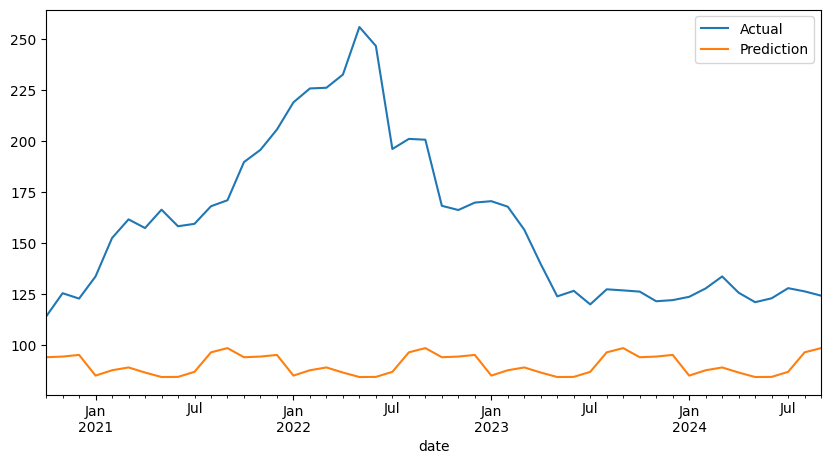

MAE: 69.31921036682128
RMSE: 79.62932755860498
MAPE: 0.4042491692873667
R-Squared: -3.3129104173324446


In [10]:

# Evaluating GridSearch results
prediction = grid_search.predict(X_test)
plot_predictions(testing_dates, y_test, prediction)
evaluate_model(y_test, prediction)

Teste Dados Estacionários

In [13]:
df = pd.read_csv("../../data library/Trigo_v1.csv", sep=";")
df = df.sort_values(by="Data")
df = df.reset_index(drop=True)
df.head()

# df['Data'] = pd.to_datetime(df['Data'])
# df = df.set_index('Data')
# monthly_summary = df.Estadual.resample('ME').mean().ffill()

df_log=df.copy()
df_diff=df.copy()

df_log["Estadual"]=np.sqrt(df['Estadual'])
df_diff["Estadual"]=df_log["Estadual"].diff().dropna()



In [14]:
df_diff

,Data,Cultivo,Estadual,País,Id,Último,Abertura,Máxima,Mínima
0,2004-03-01,Soja,NaN,50.0455,0,1.03400,1.00000,1.06400,92600.00000
1,2004-04-01,Soja,0.042021,48.7279,0,81400.00000,1.03600,1.06300,81200.00000
2,2004-05-01,Soja,-0.079639,47.4930,0,89300.00000,82800.00000,94000.00000,0.00000
3,2004-06-01,Soja,-0.486489,40.7781,0,59950.00000,89200.00000,1.03500,59900.00000
4,2004-07-01,Soja,-0.374228,37.5474,0,62725.00000,59100.00000,71200.00000,56500.00000
...,...,...,...,...,...,...,...,...,...
241,2024-05-01,Soja,0.276085,118.2335,0,1.20350,1.16100,1.25650,1.15625
242,2024-06-01,Soja,0.230279,121.3981,0,1.15050,1.20425,1.20550,1.14625
243,2024-07-01,Soja,0.048675,121.7345,0,1.02850,1.14825,1.19150,1.02050
244,2024-08-01,Soja,-0.114014,119.2007,0,98200.00000,1.03000,1.04500,93625.00000


In [15]:
df2 = df_diff[1:].copy()

df2['Data'] = pd.to_datetime(df2['Data'])
df2 = df2[["Data","Estadual"]]


df2["Month"] = df2["Data"].dt.month
df2["Quarter"] = df2["Data"].dt.quarter
df2["Year"] = df2["Data"].dt.year

train_df = df2[:(int(len(df2)*0.8))].copy()
test_df = df2[(int(len(df2)*0.8)):].copy()

In [16]:
training_data = train_df.copy()
testing_data = test_df.copy()

training_data = training_data.drop(columns=["Data"])
testing_dates = testing_data["Data"]
testing_data = testing_data.drop(columns=["Data"])

X_train = training_data[["Month", "Quarter", "Year"]]
y_train = training_data["Estadual"]

X_test = testing_data[["Month", "Quarter", "Year"]]
y_test = testing_data["Estadual"]

In [17]:
from xgboost import XGBRegressor
import lightgbm as lgb
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV

# XGBoost
cv_split = TimeSeriesSplit(n_splits=3, test_size=len(X_test))
model = XGBRegressor()
parameters = {
    "max_depth": [3, 4, 6, 5, 10],
    "learning_rate": [0.01, 0.05, 0.1, 0.2, 0.3],
    "n_estimators": [100, 300, 500, 700, 900, 1000],
    "colsample_bytree": [0.3, 0.5, 0.7]
}


grid_search = GridSearchCV(estimator=model, cv=cv_split, param_grid=parameters)
grid_search.fit(X_train, y_train)

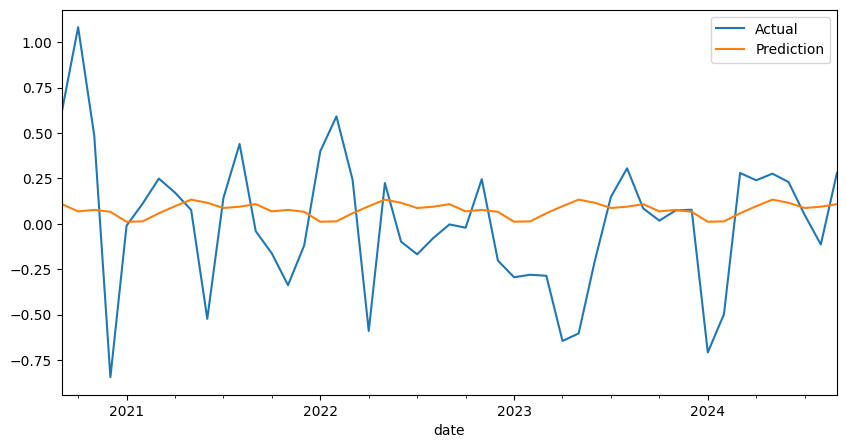

MAE: 0.28373244228054556
RMSE: 0.37602050551707905
MAPE: 1.786497761168068
R-Squared: -0.0353621842500953


In [ ]:
# Evaluating GridSearch results
prediction = grid_search.predict(X_test)
plot_predictions(testing_dates, y_test, prediction)
evaluate_model(y_test, prediction)

In [ ]:
fixed = pd.DataFrame(prediction)
fixed.rename(columns={0:"Estadual"}, inplace=True)
fixed["Estadual"].head()

0    0.108245
1    0.068259
2    0.076530
3    0.066054
4    0.011290
Name: Estadual, dtype: float32

In [ ]:
import numpy as np 
from sklearn import preprocessing as p 
  
  
min_max_scaler = p.MinMaxScaler() 
min_max_scaler.fit(y_train)
fixed["Estadual"] = min_max_scaler.transform(fixed["Estadual"])

aux_fixed = fixed["Estadual"]

  
# normalized data using MinMaxScaler 
print(aux_fixed) 

ValueError: Expected a 2-dimensional container but got <class 'pandas.core.series.Series'> instead. Pass a DataFrame containing a single row (i.e. single sample) or a single column (i.e. single feature) instead.

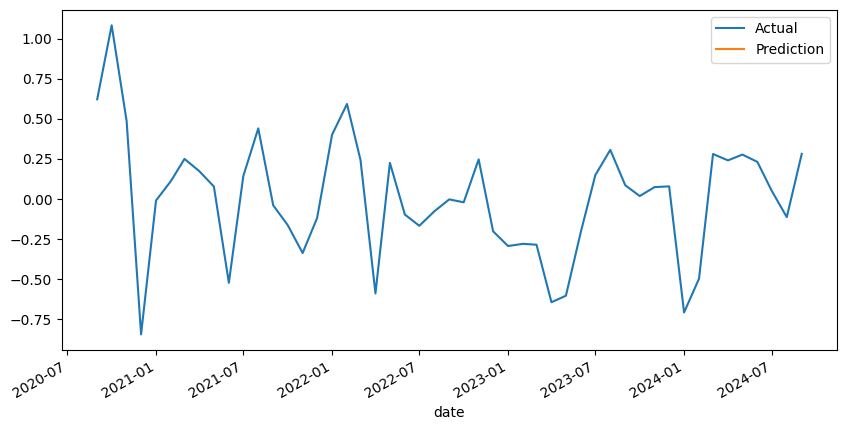

MAE: 0.6104623616461875
RMSE: 0.7089760155886744
MAPE: 9.14575810303516
R-Squared: -2.6807161571874016


In [ ]:
plot_predictions(testing_dates, y_test, fixed.Estadual)
evaluate_model(y_test, aux_fixed)